<a href="https://colab.research.google.com/github/NguyenAnhKietUIT/IS254.O11/blob/main/wikipedia/notebook/Decision_Support_System_Book_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Jupyter config

In [2]:
from IPython.core.interactiveshell import InteractiveShell

# Set shell to show all lines of output
InteractiveShell.ast_node_interactivity = 'all'

## Load data

In [3]:
import json
import pickle

In [4]:
books = []

with open('/content/drive/MyDrive/Data/found_books_filtered.ndjson', 'r') as fin:
    # Append each line to the books
    books = [json.loads(l) for l in fin]

In [5]:
print(f'Found {len(books)} books.')

Found 37040 books.


## Data preprocessing

### Remove non-book articles

In [6]:
books_with_wikipedia = [book for book in books if 'Wikipedia:' in book[0]]
books = [book for book in books if 'Wikipedia:' not in book[0]]

In [7]:
print(f'Found {len(books_with_wikipedia)} Wikipedia books.')
print(f'Found {len(books)} books.')

Found 20 Wikipedia books.
Found 37020 books.


In [8]:
[book for book in books_with_wikipedia][:1]

[['Wikipedia:Wikipedia Signpost/2014-06-25/Recent research',
  {'name': 'Global Wikipedia',
   'author': 'Pnina Fichman and Noriko Hara',
   'country': 'United States',
   'language': 'English',
   'subject': 'Wikipedia',
   'publisher': 'Rowman  &  Littlefield',
   'release_date': '2014',
   'pages': '178',
   'isbn': '978-0810891012'},
  ['User:Adler.fa',
   'User:Maximilianklein',
   'User:Piotrus',
   'User:Kimaus',
   'User:Tbayer (WMF)',
   'Rowman  &  Littlefield',
   'Indiana University Bloomington',
   'User:Maximilianklein',
   'User talk:Maximilianklein',
   'File:Immanuel Kant (painted portrait).jpg',
   'Immanuel Kant',
   'PageRank',
   'CheiRank',
   'm:Research:Newsletter/2013/April#How_Wikipedia.27s_Google_matrix_differs_for_politicians_and_artists',
   'm:Research:Newsletter/2013/July#Multilingual_ranking_analysis:_Napoleon_and_Michael_Jackson_as_Wikipedia.27s_.22global_heroes.22',
   'DBpedia',
   'User:Piotrus',
   'OpenSym',
   'Chinese Wikipedia',
   'Baidu Baike'

In [9]:
n = 4

print("Book title:", books[n][0])
print("Book info:", books[n][1])
print("Book detail:", books[n][2])
print("Book links:", books[n][3])
print("Release date:", books[n][4])
print("Book page:", books[n][5])

Book title: Day of the Dogs
Book info: {'name': 'Day of the Dogs', 'author': 'Andrew Cartmel', 'cover_artist': 'Karl Richardson', 'series': 'Strontium Dog', 'genre': 'Science fiction', 'publisher': 'Black Flame', 'pub_date': 'July 2005', 'pages': '256', 'isbn': '1844162184', 'preceded_by': 'Ruthless', 'followed_by': 'A Fistful of Strontium'}
Book detail: ['Andrew Cartmel', 'Strontium Dog', 'Black Flame', 'Andrew Cartmel', 'science fiction', 'comic book', 'Strontium Dog', 'Johnny Alpha', 'Middenface McNulty', 'wild west', 'Category:Strontium Dog', 'Category:Novels by Andrew Cartmel']
Book links: ['http://www.2000adreview.co.uk/reviews/extra/2005/books/dayofdog/strontium_dog_day_of_the_dogs.shtml']
Release date: 2014-05-05T21:37:03Z
Book page: 598


### Map book - index

In [10]:
book_index = {book[0]: idx for idx, book in enumerate(books)}
index_book = {idx: book for book, idx in book_index.items()}

In [11]:
# Find the index of "Anna Karenina"
anna_karenina_index = book_index['Anna Karenina']
print("Index of 'Anna Karenina':", anna_karenina_index)

Index of 'Anna Karenina': 22494


In [12]:
# Find the book associated with index 22494
book_22494 = index_book[22494]
print("Book at index 22494:", book_22494)

Book at index 22494: Anna Karenina


### Flatten

In [13]:
from itertools import chain

In [15]:
wikilinks = list(chain(*[book[2] for book in books]))

In [16]:
wikilinks_other_books = [link for link in wikilinks if link in book_index.keys()]

In [17]:
from collections import Counter, OrderedDict

def count_items(l):
    """Return ordered dictionary of counts of objects in `l`"""

    # Create a counter object
    counts = Counter(l)

    # Sort by highest count first and place in ordered dictionary
    counts = sorted(counts.items(), key = lambda x: x[1], reverse = True)
    counts = OrderedDict(counts)

    return counts

In [18]:
# Find set of wikilinks for each book and convert to a flattened list
unique_wikilinks = list(chain(*[list(set(book[2])) for book in books]))

wikilink_counts = count_items(unique_wikilinks)
list(wikilink_counts.items())[:10]

[('Hardcover', 7489),
 ('Paperback', 7311),
 ('Wikipedia:WikiProject Books', 6043),
 ('Wikipedia:WikiProject Novels', 6015),
 ('English language', 4185),
 ('United States', 3060),
 ('Science fiction', 3030),
 ('The New York Times', 2727),
 ('science fiction', 2502),
 ('novel', 1979)]

In [20]:
wikilinks = [link.lower() for link in unique_wikilinks]

wikilink_counts = count_items(wikilinks)
list(wikilink_counts.items())[:5]

[('paperback', 8740),
 ('hardcover', 8648),
 ('wikipedia:wikiproject books', 6043),
 ('wikipedia:wikiproject novels', 6016),
 ('science fiction', 5665)]

### Clean data

In [21]:
to_remove = ['hardcover', 'paperback', 'hardback', 'e-book', 'wikipedia:wikiproject books', 'wikipedia:wikiproject novels']
for t in to_remove:
    wikilinks.remove(t)
    _ = wikilink_counts.pop(t)

In [23]:
# Limit to greater than 3 links
links = [t[0] for t in wikilink_counts.items() if t[1] >= 4]

In [24]:
# Find set of book wikilinks for each book
unique_wikilinks_books = list(chain(*[list(set(link for link in book[2] if link in book_index.keys())) for book in books]))

# Count the number of books linked to by other books
wikilink_book_counts = count_items(unique_wikilinks_books)
list(wikilink_book_counts.items())[:10]

[('The Encyclopedia of Science Fiction', 127),
 ('The Discontinuity Guide', 104),
 ('The Encyclopedia of Fantasy', 63),
 ('Dracula', 55),
 ('Encyclopædia Britannica', 51),
 ('Nineteen Eighty-Four', 51),
 ('Don Quixote', 49),
 ('The Wonderful Wizard of Oz', 49),
 ("Alice's Adventures in Wonderland", 47),
 ('Jane Eyre', 39)]

In [25]:
link_index = {link: idx for idx, link in enumerate(links)}
index_link = {idx: link for link, idx in link_index.items()}

In [26]:
print(link_index['the economist'])

300


In [27]:
print(index_link[300])

the economist


In [28]:
print(f'There are {len(link_index)} wikilinks that will be used.')

There are 41758 wikilinks that will be used.


# Supervised Machine Learning Task
Now that we have clean data, we'll move on to the second step: developing a supervised machine learning task to train an embedding neural network. As a reminder, we'll state the problem as: given a book title and a link, identify if the link is in the book's article.

## Preparing

In [29]:
pairs = []

# Iterate through each book
for book in books:
    # Iterate through the links in the book
    pairs.extend((book_index[book[0]], link_index[link.lower()]) for link in book[2] if link.lower() in links)

In [30]:
import numpy as np
import random

In [31]:
random.seed(100)

def generate_batch(pairs, n_positive = 50, negative_ratio = 1.0, classification = False):
    """Generate batches of samples for training"""
    batch_size = n_positive * (1 + negative_ratio)
    batch = np.zeros((batch_size, 3))

    # Adjust label based on task
    if classification:
        neg_label = 0
    else:
        neg_label = -1

    # This creates a generator
    while True:
        # randomly choose positive examples
        for idx, (book_id, link_id) in enumerate(random.sample(pairs, n_positive)):
            batch[idx, :] = (book_id, link_id, 1)

        # Increment idx by 1
        idx += 1

        # Add negative examples until reach batch size
        while idx < batch_size:

            # random selection
            random_book = random.randrange(len(books))
            random_link = random.randrange(len(links))

            # Check to make sure this is not a positive example
            if (random_book, random_link) not in set(pairs):

                # Add to batch and increment index
                batch[idx, :] = (random_book, random_link, neg_label)
                idx += 1

        # Make sure to shuffle order
        np.random.shuffle(batch)
        yield {'book': batch[:, 0], 'link': batch[:, 1]}, batch[:, 2]

In [32]:
next(generate_batch(pairs, n_positive = 2, negative_ratio = 2))

({'book': array([ 7206., 29814., 25757.,  6895., 28410., 22162.]),
  'link': array([34924., 11452., 22920.,   260., 33217.,  5588.])},
 array([-1., -1., -1.,  1., -1.,  1.]))

In [33]:
x, y = next(generate_batch(pairs, n_positive = 2, negative_ratio = 2))

# Show a few example training pairs
for label, b_idx, l_idx in zip(y, x['book'], x['link']):
    print(f'Book: {index_book[b_idx]:30} Link: {index_link[l_idx]:40} Label: {label}')

Book: Des Imagistes                  Link: august strindberg                        Label: -1.0
Book: The Soul of the Robot          Link: p.c. cast                                Label: -1.0
Book: Deep Six (novel)               Link: president of the united states           Label: 1.0
Book: Soul Music (novel)             Link: peter crowther                           Label: -1.0
Book: Bag of Bones                   Link: category:novels by stephen king          Label: 1.0
Book: The Counterfeit Man            Link: gerald gardner (wiccan)                  Label: -1.0


## Embedding

In [34]:
from keras.layers import Input, Embedding, Dot, Reshape, Dense
from keras.models import Model

In [35]:
def book_embedding_model(embedding_size = 50, classification = False):
    """Model to embed books and wikilinks using the functional API.
       Trained to discern if a link is present in a article"""

    # Both inputs are 1-dimensional
    book = Input(name = 'book', shape = [1])
    link = Input(name = 'link', shape = [1])

    # Embedding the book (shape will be (None, 1, 50))
    book_embedding = Embedding(name = 'book_embedding',
                               input_dim = len(book_index),
                               output_dim = embedding_size)(book)

    # Embedding the link (shape will be (None, 1, 50))
    link_embedding = Embedding(name = 'link_embedding',
                               input_dim = len(link_index),
                               output_dim = embedding_size)(link)

    # Merge the layers with a dot product along the second axis (shape will be (None, 1, 1))
    merged = Dot(name = 'dot_product', normalize = True, axes = 2)([book_embedding, link_embedding])

    # Reshape to be a single number (shape will be (None, 1))
    merged = Reshape(target_shape = [1])(merged)

    # If classifcation, add extra layer and loss function is binary cross entropy
    if classification:
        merged = Dense(1, activation = 'sigmoid')(merged)
        model = Model(inputs = [book, link], outputs = merged)
        model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

    # Otherwise loss function is mean squared error
    else:
        model = Model(inputs = [book, link], outputs = merged)
        model.compile(optimizer = 'Adam', loss = 'mse')

    return model

In [36]:
# Instantiate model and show parameters
model = book_embedding_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 book (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 link (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 book_embedding (Embedding)  (None, 1, 50)                1851000   ['book[0][0]']                
                                                                                                  
 link_embedding (Embedding)  (None, 1, 50)                2087900   ['link[0][0]']                
                                                                                              

## Training

In [37]:
n_positive = 1024

In [ ]:
gen = generate_batch(pairs, n_positive, negative_ratio = 2)

# Train
h = model.fit_generator(gen, epochs = 15,
                        steps_per_epoch = len(pairs) // n_positive,
                        verbose = 2)

Epoch 1/15


<ipython-input-45-fbc6e88c7b0e>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  h = model.fit_generator(gen, epochs = 15,


754/754 - 51s - loss: 0.9568 - 51s/epoch - 68ms/step
Epoch 2/15
754/754 - 50s - loss: 0.7208 - 50s/epoch - 67ms/step
Epoch 3/15
754/754 - 50s - loss: 0.5034 - 50s/epoch - 66ms/step
Epoch 4/15
754/754 - 51s - loss: 0.4621 - 51s/epoch - 68ms/step
Epoch 5/15
754/754 - 56s - loss: 0.4451 - 56s/epoch - 74ms/step
Epoch 6/15
754/754 - 57s - loss: 0.4359 - 57s/epoch - 75ms/step
Epoch 7/15
754/754 - 58s - loss: 0.4293 - 58s/epoch - 77ms/step
Epoch 8/15
754/754 - 55s - loss: 0.4254 - 55s/epoch - 73ms/step
Epoch 9/15
754/754 - 54s - loss: 0.4220 - 54s/epoch - 72ms/step
Epoch 10/15
754/754 - 49s - loss: 0.4196 - 49s/epoch - 66ms/step
Epoch 11/15
754/754 - 50s - loss: 0.4168 - 50s/epoch - 66ms/step
Epoch 12/15
754/754 - 50s - loss: 0.4154 - 50s/epoch - 66ms/step
Epoch 13/15
754/754 - 49s - loss: 0.4135 - 49s/epoch - 65ms/step
Epoch 14/15
754/754 - 49s - loss: 0.4125 - 49s/epoch - 65ms/step
Epoch 15/15
754/754 - 49s - loss: 0.4110 - 49s/epoch - 65ms/step


In [ ]:
model.save('/content/drive/MyDrive/Model/first_attempt.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Preview model

In [38]:
from keras.models import load_model

In [39]:
model = load_model('/content/drive/MyDrive/Model/first_attempt.h5')

In [40]:
# Extract embeddings
book_layer = model.get_layer('book_embedding')
book_weights = book_layer.get_weights()[0]
book_weights.shape

(37020, 50)

In [41]:
book_weights = book_weights / np.linalg.norm(book_weights, axis = 1).reshape((-1, 1))
book_weights[0][:10]
np.sum(np.square(book_weights[0]))

array([ 0.13644068,  0.28506666, -0.08673827, -0.0759801 , -0.09666864,
       -0.15472494,  0.19448233, -0.00662847,  0.17184754, -0.125705  ],
      dtype=float32)

1.0

## Testing

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 15

In [43]:
def find_similar(name, weights, index_name = 'book', n = 10, least = False, return_dist = False, plot = False):
    """Find n most similar items (or least) to name based on embeddings. Option to also plot the results"""

    # Select index and reverse index
    if index_name == 'book':
        index = book_index
        rindex = index_book
    elif index_name == 'page':
        index = link_index
        rindex = index_link

    # Check to make sure `name` is in index
    try:
        # Calculate dot product between book and all others
        dists = np.dot(weights, weights[index[name]])
    except KeyError:
        print(f'{name} Not Found.')
        return

    # Sort distance indexes from smallest to largest
    sorted_dists = np.argsort(dists)

    # Plot results if specified
    if plot:

        # Find furthest and closest items
        furthest = sorted_dists[:(n // 2)]
        closest = sorted_dists[-n-1: len(dists) - 1]
        items = [rindex[c] for c in furthest]
        items.extend(rindex[c] for c in closest)

        # Find furthest and closets distances
        distances = [dists[c] for c in furthest]
        distances.extend(dists[c] for c in closest)

        colors = ['r' for _ in range(n //2)]
        colors.extend('g' for _ in range(n))

        data = pd.DataFrame({'distance': distances}, index = items)

        # Horizontal bar chart
        data['distance'].plot.barh(color = colors, figsize = (10, 8),
                                   edgecolor = 'k', linewidth = 2)
        plt.xlabel('Cosine Similarity');
        plt.axvline(x = 0, color = 'k');

        # Formatting for italicized title
        name_str = f'{index_name.capitalize()}s Most and Least Similar to'
        for word in name.split():
            # Title uses latex for italize
            name_str += ' $\it{' + word + '}$'
        plt.title(name_str, x = 0.2, size = 28, y = 1.05)

        return None

    # If specified, find the least similar
    if least:
        # Take the first n from sorted distances
        closest = sorted_dists[:n]

        print(f'{index_name.capitalize()}s furthest from {name}.\n')

    # Otherwise find the most similar
    else:
        # Take the last n sorted distances
        closest = sorted_dists[-n:]

        # Need distances later on
        if return_dist:
            return dists, closest


        print(f'{index_name.capitalize()}s closest to {name}.\n')

    # Need distances later on
    if return_dist:
        return dists, closest


    # Print formatting
    max_width = max([len(rindex[c]) for c in closest])

    # Print the most similar and distances
    for c in reversed(closest):
        print(f'{index_name.capitalize()}: {rindex[c]:{max_width + 2}} Similarity: {dists[c]:.{2}}')

In [44]:
find_similar('War and Peace', book_weights)

Books closest to War and Peace.

Book: War and Peace               Similarity: 1.0
Book: Anna Karenina               Similarity: 0.92
Book: Dead Souls                  Similarity: 0.92
Book: Demons (Dostoevsky novel)   Similarity: 0.92
Book: The Master and Margarita    Similarity: 0.91
Book: The Red and the Black       Similarity: 0.9
Book: Buddenbrooks                Similarity: 0.89
Book: The Idiot                   Similarity: 0.89
Book: Crime and Punishment        Similarity: 0.89
Book: Poor Folk                   Similarity: 0.89


In [45]:
find_similar('War and Peace', book_weights, least = True, n = 5)

Books furthest from War and Peace.

Book: Hidden Warrior                       Similarity: -0.52
Book: Condemnation (novel)                 Similarity: -0.53
Book: Chicks in Chainmail                  Similarity: -0.53
Book: ITT: The Management of Opportunity   Similarity: -0.54
Book: Fear (anthology)                     Similarity: -0.55


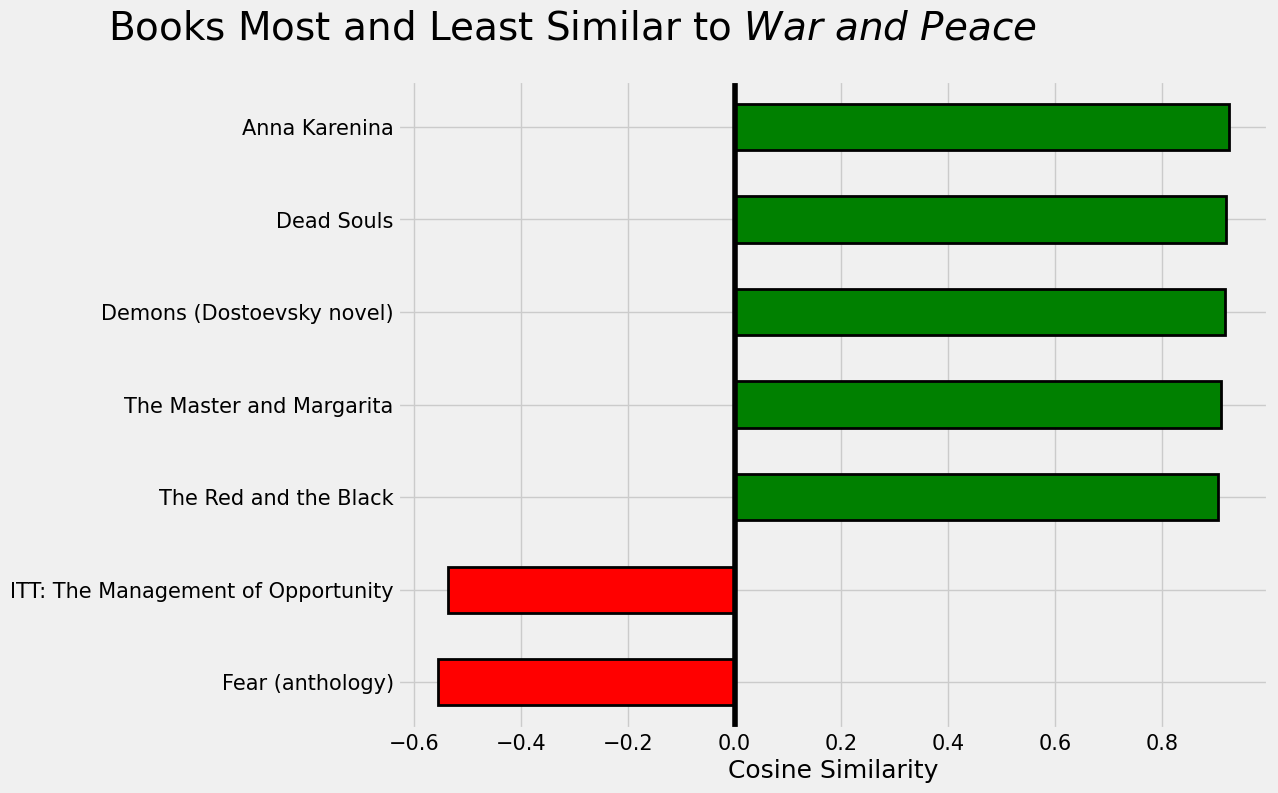

In [46]:
find_similar('War and Peace', book_weights, n = 5, plot = True)

In [47]:
def get_similar_array(name, weights, index_name='book', n=10, least=False):
    """Find n most similar items (or least) to name based on embeddings. Option to also plot the results"""

    # Select index and reverse index
    if index_name == 'book':
        index = book_index
        rindex = index_book
    elif index_name == 'page':
        index = link_index
        rindex = index_link

    # Check to make sure `name` is in index
    try:
        # Calculate dot product between book and all others
        dists = np.dot(weights, weights[index[name]])
    except KeyError:
        print(f'{name} Not Found.')
        return []

    # Sort distance indexes from smallest to largest
    sorted_dists = np.argsort(dists)

    # Result list to store valid results
    result_list = []

    # If specified, find the least similar
    if least:
        # Take the first n from sorted distances
        closest = sorted_dists[:n]

    # Otherwise find the most similar
    else:
        # Take the last n sorted distances
        closest = sorted_dists[-n:]

    # Print formatting
    max_width = max([len(rindex[c]) for c in closest])

    # Append the most similar and distances to the result list
    for c in reversed(closest):
      if rindex[c] != name:  # Skip the input name
        result_list.append(rindex[c])

    return result_list

In [ ]:
# Create a list to store results
regression_book_recommend_list = []

# Iterate over index_book
for key in index_book:
    name = index_book[key]

    # Call get_similar_array and append the result to the list
    similar_items = get_similar_array(name, book_weights, n = 7)
    regression_book_recommend_list.append((name, similar_items))

In [ ]:
# Save result_list to a file
with open('/content/drive/MyDrive/Data/regression_book_recommend_list.pkl', 'wb') as file:
    pickle.dump(regression_book_recommend_list, file)

In [ ]:
# Iterate through the result_list
for name, similar_items in regression_book_recommend_list:
    # Check if the name is 'War and Peace'
    if name == 'War and Peace':
        # Print the similar_items
        print(f"Similar items for '{name}': {similar_items}")

Similar items for 'War and Peace': ['Anna Karenina', 'The Master and Margarita', 'Demons (Dostoevsky novel)', 'Dead Souls', 'Crime and Punishment', 'The Idiot']


In [48]:
def extract_weights(name, model):
    """Extract weights from a neural network model"""

    # Extract weights
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]

    # Normalize
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))
    return weights

In [49]:
link_weights = extract_weights('link_embedding', model)

In [ ]:
# Create a list to store results
regression_link_recommend_list = []

# Iterate over index_link
for key in index_link:
    name = index_link[key]

    # Call get_similar_array and append the result to the list
    similar_items = get_similar_array(name, link_weights, index_name = 'page', n = 7)
    regression_link_recommend_list.append((name, similar_items))

In [ ]:
# Save result_list to a file
with open('/content/drive/MyDrive/Data/regression_link_recommend_list.pkl', 'wb') as file:
    pickle.dump(regression_link_recommend_list, file)

In [ ]:
# Iterate through the result_list
for name, similar_items in regression_link_recommend_list:
    # Check if the name is 'science fiction'
    if name == 'science fiction':
        # Print the similar_items
        print(f"Similar items for '{name}': {similar_items}")

Similar items for 'science fiction': ['category:american science fiction novels', 'tor books', 'bantam books', 'category:doubleday (publisher) books', 'ballantine books', 'anthology']


## Embedding class

In [ ]:
model_class = book_embedding_model(50, classification = True)
gen = generate_batch(pairs, n_positive, negative_ratio=2, classification = True)

In [ ]:
# Train the model to learn embeddings
h = model_class.fit_generator(gen, epochs = 15, steps_per_epoch= len(pairs) // n_positive,
                            verbose = 2)

Epoch 1/15


<ipython-input-59-4f0b8c0e7897>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  h = model_class.fit_generator(gen, epochs = 15, steps_per_epoch= len(pairs) // n_positive,


754/754 - 48s - loss: 0.6248 - accuracy: 0.7035 - 48s/epoch - 64ms/step
Epoch 2/15
754/754 - 47s - loss: 0.4436 - accuracy: 0.8522 - 47s/epoch - 63ms/step
Epoch 3/15
754/754 - 46s - loss: 0.3225 - accuracy: 0.9004 - 46s/epoch - 61ms/step
Epoch 4/15
754/754 - 47s - loss: 0.2646 - accuracy: 0.9267 - 47s/epoch - 62ms/step
Epoch 5/15
754/754 - 47s - loss: 0.2259 - accuracy: 0.9422 - 47s/epoch - 63ms/step
Epoch 6/15
754/754 - 49s - loss: 0.1966 - accuracy: 0.9527 - 49s/epoch - 65ms/step
Epoch 7/15
754/754 - 53s - loss: 0.1731 - accuracy: 0.9602 - 53s/epoch - 70ms/step
Epoch 8/15
754/754 - 53s - loss: 0.1538 - accuracy: 0.9661 - 53s/epoch - 70ms/step
Epoch 9/15
754/754 - 53s - loss: 0.1377 - accuracy: 0.9705 - 53s/epoch - 70ms/step
Epoch 10/15
754/754 - 62s - loss: 0.1237 - accuracy: 0.9742 - 62s/epoch - 82ms/step
Epoch 11/15
754/754 - 47s - loss: 0.1118 - accuracy: 0.9771 - 47s/epoch - 62ms/step
Epoch 12/15
754/754 - 63s - loss: 0.1012 - accuracy: 0.9794 - 63s/epoch - 83ms/step
Epoch 13/15


In [ ]:
model_class.save('/content/drive/MyDrive/Model/first_attempt_class.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## EC Testing

In [50]:
model_classification = load_model('/content/drive/MyDrive/Model/first_attempt_class.h5')

In [51]:
book_weights_class = extract_weights('book_embedding', model_classification)
book_weights_class.shape

(37020, 50)

In [ ]:
# Create a list to store results
classification_book_recommend_list = []

# Iterate over index_book
for key in index_book:
    name = index_book[key]

    # Call get_similar_array and append the result to the list
    similar_items = get_similar_array(name, book_weights_class, n = 7)
    classification_book_recommend_list.append((name, similar_items))

In [ ]:
# Save result_list to a file
with open('/content/drive/MyDrive/Data/classification_book_recommend_list.pkl', 'wb') as file:
    pickle.dump(classification_book_recommend_list, file)

In [52]:
link_weights_class = extract_weights('link_embedding', model_classification)

In [ ]:
# Create a list to store results
classification_link_recommend_list = []

# Iterate over index_link
for key in index_link:
    name = index_link[key]

    # Call get_similar_array and append the result to the list
    similar_items = get_similar_array(name, link_weights_class, index_name = 'page', n = 7)
    classification_link_recommend_list.append((name, similar_items))

In [ ]:
# Save result_list to a file
with open('/content/drive/MyDrive/Data/classification_link_recommend_list.pkl', 'wb') as file:
    pickle.dump(classification_link_recommend_list, file)

# Visualizations

## Manifold Embeddings

In [53]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86831 sha256=ec0e614671f8a29126c038532b5608c10d4c17d6b166b620838d412d8a57832f
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55615 sha256=050cee4e66ad3eb3f982aa4fcc3d54d77da43fd2cffa9a21326f37646807a547
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [54]:
from sklearn.manifold import TSNE
from umap import UMAP

In [55]:
def reduce_dim(weights, components = 3, method = 'tsne'):
    """Reduce dimensions of embeddings"""
    if method == 'tsne':
        return TSNE(components, metric = 'cosine').fit_transform(weights)
    elif method == 'umap':
        # Might want to try different parameters for UMAP
        return UMAP(n_components=components, metric = 'cosine',
                    init = 'random', n_neighbors = 5).fit_transform(weights)

In [56]:
book_r = reduce_dim(book_weights_class, components = 2, method = 'tsne')
book_r.shape

(37020, 2)

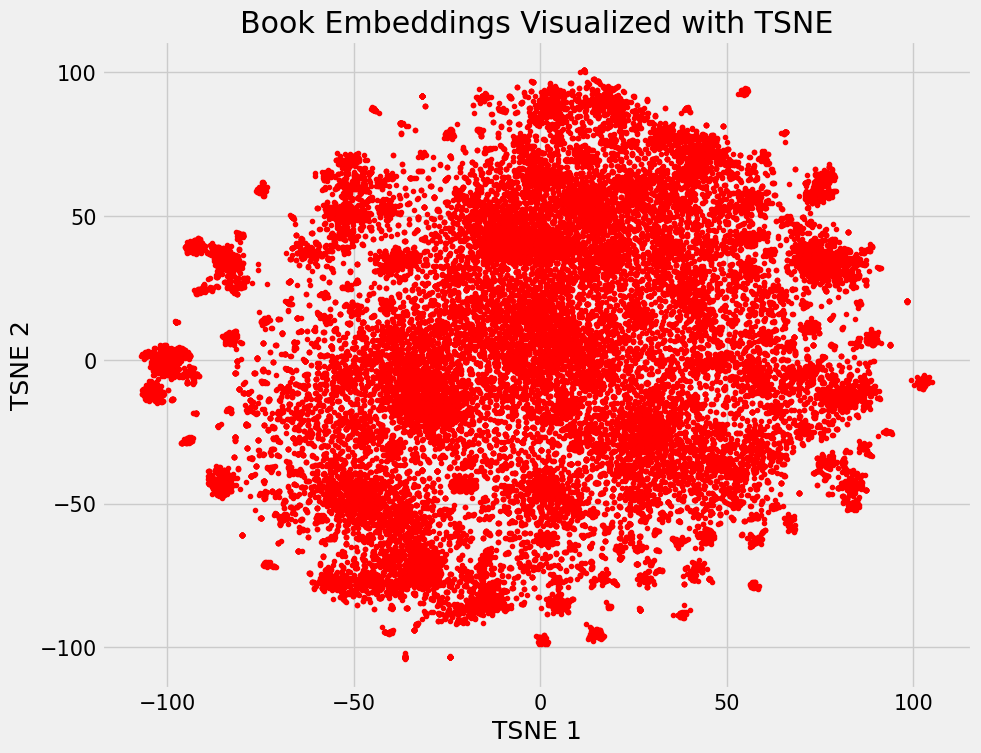

In [57]:
InteractiveShell.ast_node_interactivity = 'last'

plt.figure(figsize = (10, 8))
plt.plot(book_r[:, 0], book_r[:, 1], 'r.')
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Book Embeddings Visualized with TSNE');

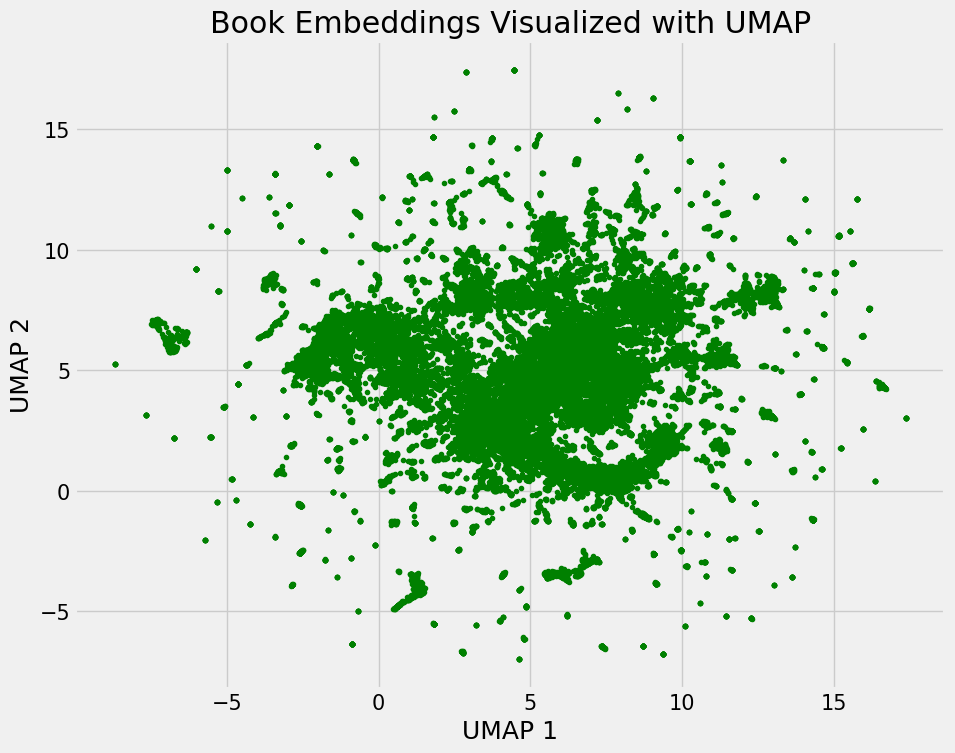

In [58]:
book_ru = reduce_dim(book_weights_class, components = 2, method = 'umap')

plt.figure(figsize = (10, 8))
plt.plot(book_ru[:, 0], book_ru[:, 1], 'g.');
plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2'); plt.title('Book Embeddings Visualized with UMAP');

In [59]:
info = list(chain(*[set(book[1]) for book in books]))
info_counts = count_items(info)
list(info_counts.items())[:10]

[('name', 36400),
 ('author', 35557),
 ('language', 32869),
 ('country', 30693),
 ('publisher', 30618),
 ('image', 28751),
 ('pages', 26090),
 ('media_type', 26016),
 ('genre', 25966),
 ('isbn', 24934)]

In [60]:
genres = [book[1].get('genre', 'None').lower() for book in books]

# Remove genres not found
genre_counts = count_items(genres)
del genre_counts['none']
list(genre_counts.items())[:10]

[('science fiction', 2177),
 ('novel', 1641),
 ('non-fiction', 1270),
 ('fantasy', 974),
 ('fantasy novel', 780),
 ('historical novel', 582),
 ('science fiction novel', 571),
 ('fiction', 559),
 ('crime novel', 424),
 ("children's novel", 313)]

In [62]:
# Include 10 most popular genres
genre_to_include = list(genre_counts.keys())[:10]

In [63]:
idx_include = []
genres = []

for i, book in enumerate(books):
    if 'genre' in book[1].keys():
        if book[1]['genre'].lower() in genre_to_include:
            idx_include.append(i)
            genres.append(book[1]['genre'].capitalize())

len(idx_include)

9291

In [64]:
ints, gen = pd.factorize(genres)
gen[:5]

array(['Science fiction', 'Novel', 'Non-fiction', 'Fiction',
       'Historical novel'], dtype=object)

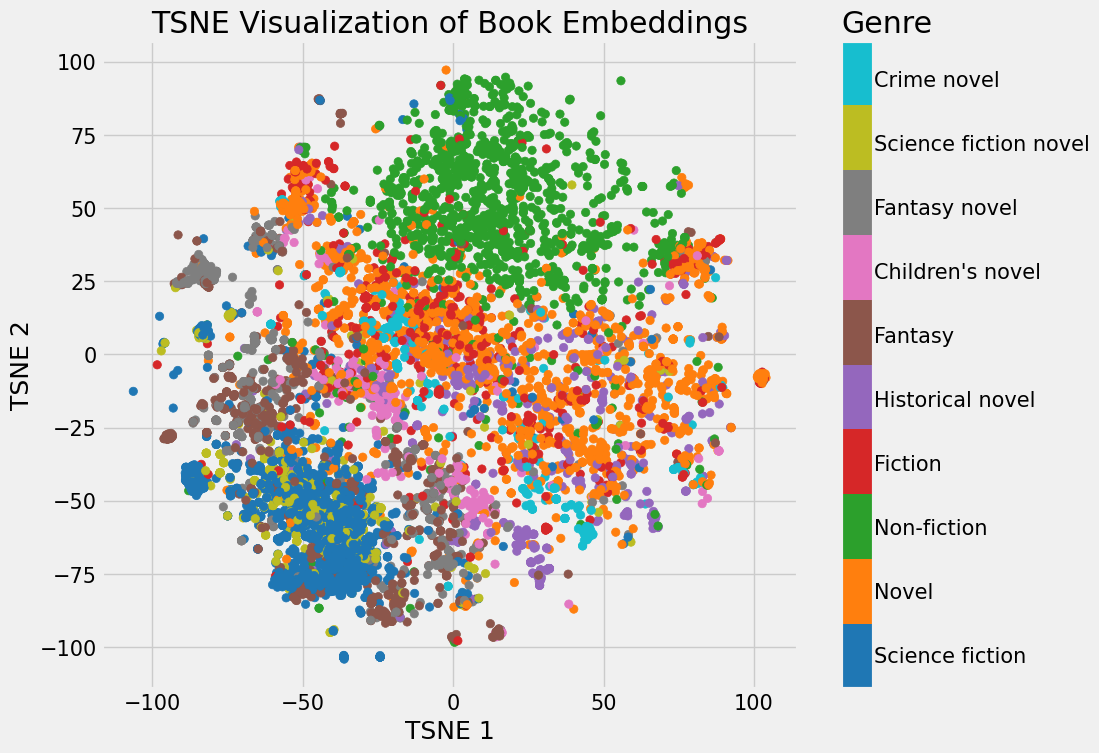

In [65]:
plt.figure(figsize = (10, 8))

# Plot embedding
plt.scatter(book_r[idx_include, 0], book_r[idx_include, 1],
            c = ints, cmap = plt.cm.tab10)

# Add colorbar and appropriate labels
cbar = plt.colorbar()
cbar.set_ticks([])
for j, lab in enumerate(gen):
    cbar.ax.text(1, (2 * j + 1) / 2.25, lab, ha='left', va='center')
cbar.ax.set_title('Genre', loc = 'left')


plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('TSNE Visualization of Book Embeddings');

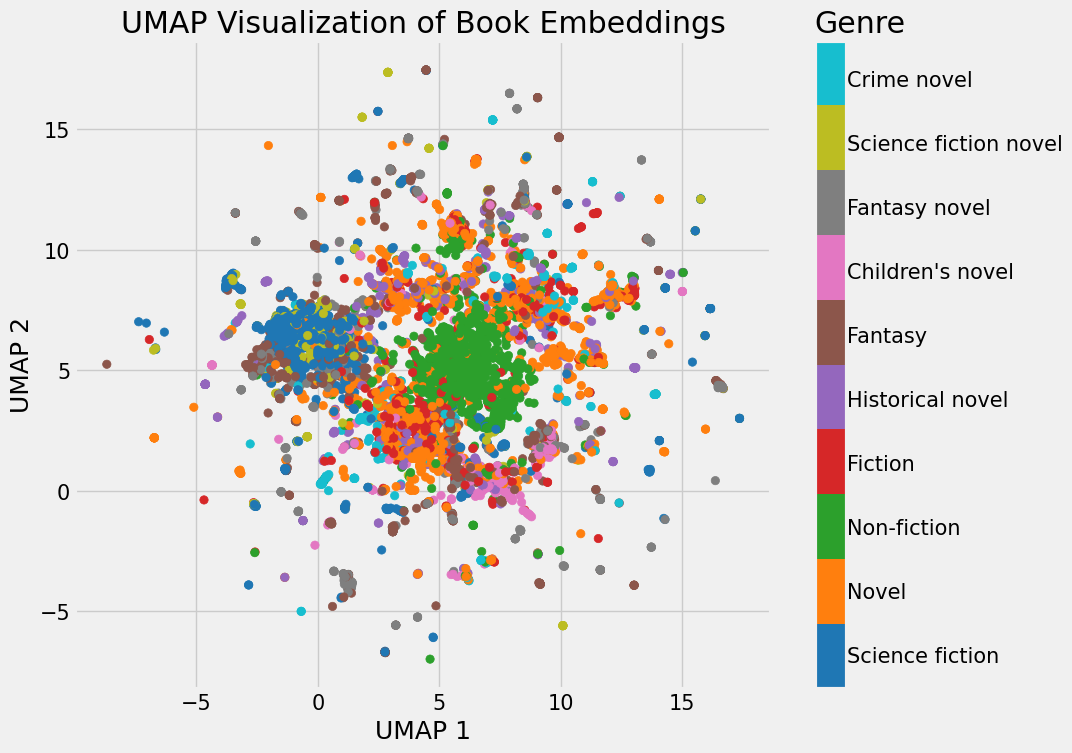

In [66]:
plt.figure(figsize = (10, 8))

# Plot embedding
plt.scatter(book_ru[idx_include, 0], book_ru[idx_include, 1],
            c = ints, cmap = plt.cm.tab10)

# Add colorbar and appropriate labels
cbar = plt.colorbar()
cbar.set_ticks([])
for j, lab in enumerate(gen):
    cbar.ax.text(1, (2 * j + 1) / 2.25, lab, ha='left', va='center')
cbar.ax.set_title('Genre', loc = 'left')


plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2'); plt.title('UMAP Visualization of Book Embeddings');

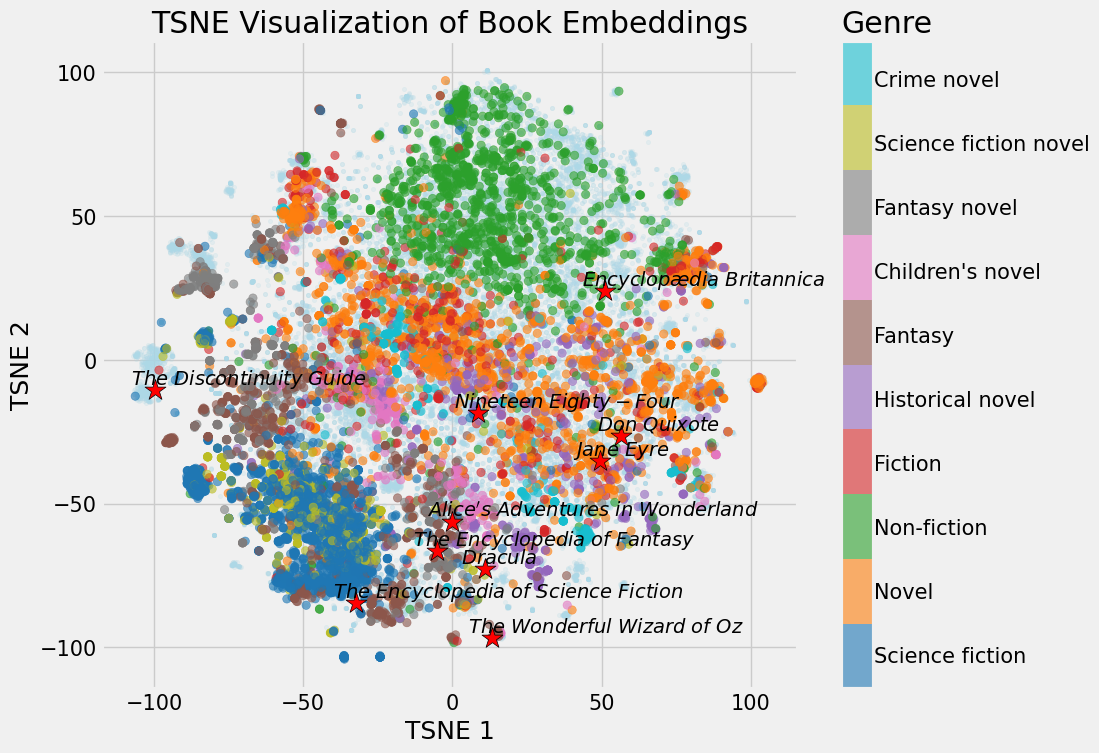

In [67]:
plt.figure(figsize = (10, 8))

# Plot all books
plt.scatter(book_r[:, 0], book_r[:, 1], marker = '.', color = 'lightblue', alpha = 0.2)

# Plot genres
plt.scatter(book_r[idx_include, 0], book_r[idx_include, 1],
            c = ints, cmap = plt.cm.tab10, alpha = 0.6)

# Add colorbar and appropriate labels
cbar = plt.colorbar()
cbar.set_ticks([])
for j, lab in enumerate(gen):
    cbar.ax.text(1, (2 * j + 1) / 2.25, lab, ha='left', va='center')

cbar.ax.set_title('Genre', loc = 'left')
plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('TSNE Visualization of Book Embeddings');

for book in list(wikilink_book_counts.keys())[:10]:

    x, y = book_r[book_index[book], 0], book_r[book_index[book], 1];
    # Italize book title using latex
    s =  ''.join([' $\it{' + word + '}$' for word in book.split()])
    _ = plt.scatter(x, y, s = 250, color = 'r',
                    marker = '*', edgecolor = 'k')
    _ = plt.text(x - 10, y + 2, s, fontsize = 14);

In [81]:
def plot_by_attribute(attribute):
    """Color book embedding by `attribute`"""
    # Find all the attribute values
    attrs = [book[1].get(attribute, 0) for book in books]

    # Remove attributes not found
    attr_counts = count_items(attrs)
    del attr_counts[0]

    # Include 10 most popular attributes
    attr_to_include, counts = list(attr_counts.keys())[:10], list(attr_counts.values())[:10]

    idx_include = []
    attributes = []

    # Iterate through books searching for the attribute
    for i, book in enumerate(books):
        # Limit to books with the attribute
        if attribute in book[1].keys():
            # Limit to attribute in the 10 most popular
            if book[1][attribute] in attr_to_include:
                idx_include.append(i)
                attributes.append(book[1][attribute])

    # Map to integers
    ints, attrs = pd.factorize(attributes)
    plt.figure(figsize = (12, 10))

    plt.scatter(book_r[:, 0], book_r[:, 1], marker = '.', color = 'lightblue', alpha = 0.2)

    # Plot embedding with only specific attribute highlighted
    plt.scatter(book_r[idx_include, 0], book_r[idx_include, 1], alpha = 0.6,
                c = ints, cmap = plt.cm.tab10, marker = 'o', s = 50)

    # Add colorbar and appropriate labels
    cbar = plt.colorbar()
    cbar.set_ticks([])
    tick_labels = [f'{attr}: {count}' for attr, count in zip(attr_to_include, counts)]
    # Labeling
    for j, lab in enumerate(tick_labels):
        cbar.ax.text(1, (2 * j + 1) / (len(tick_labels) / 4.5), lab, ha='left', va='center')
    cbar.ax.set_title(f'{attribute.capitalize()}: Count', loc = 'left')


    plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title(f'Book Embeddings with {attribute.capitalize()}');

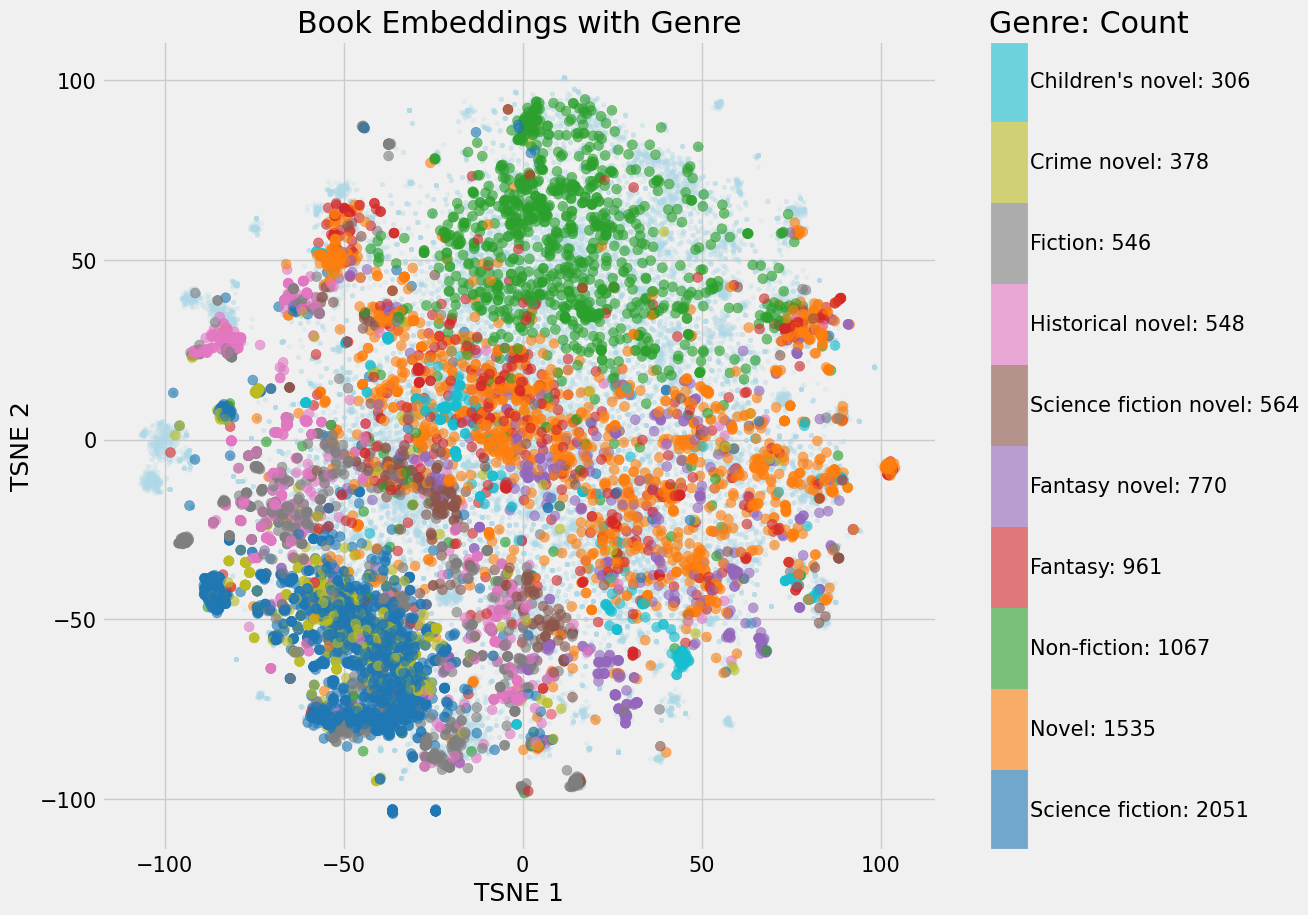

In [82]:
plot_by_attribute('genre')

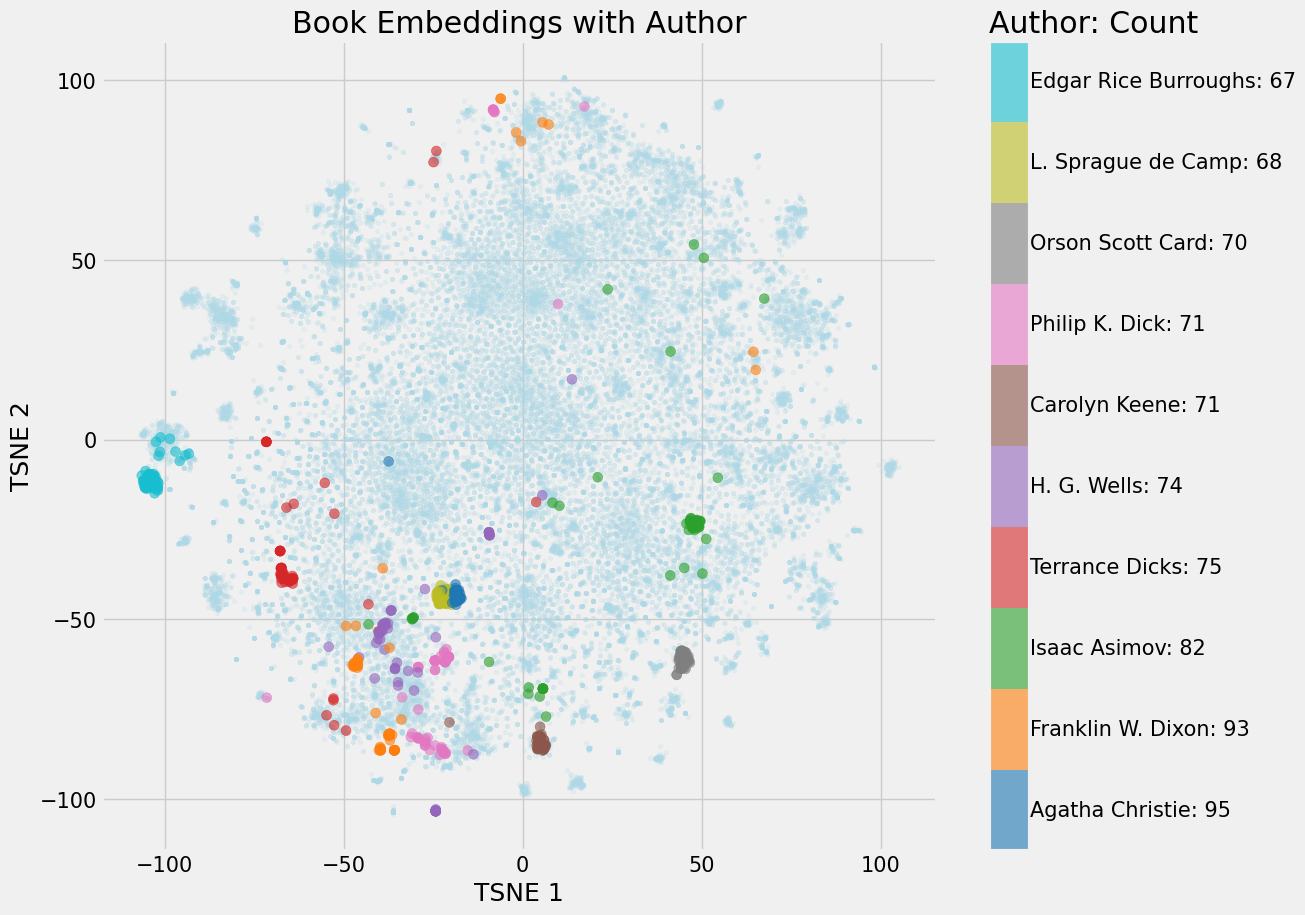

In [83]:
plot_by_attribute('author')

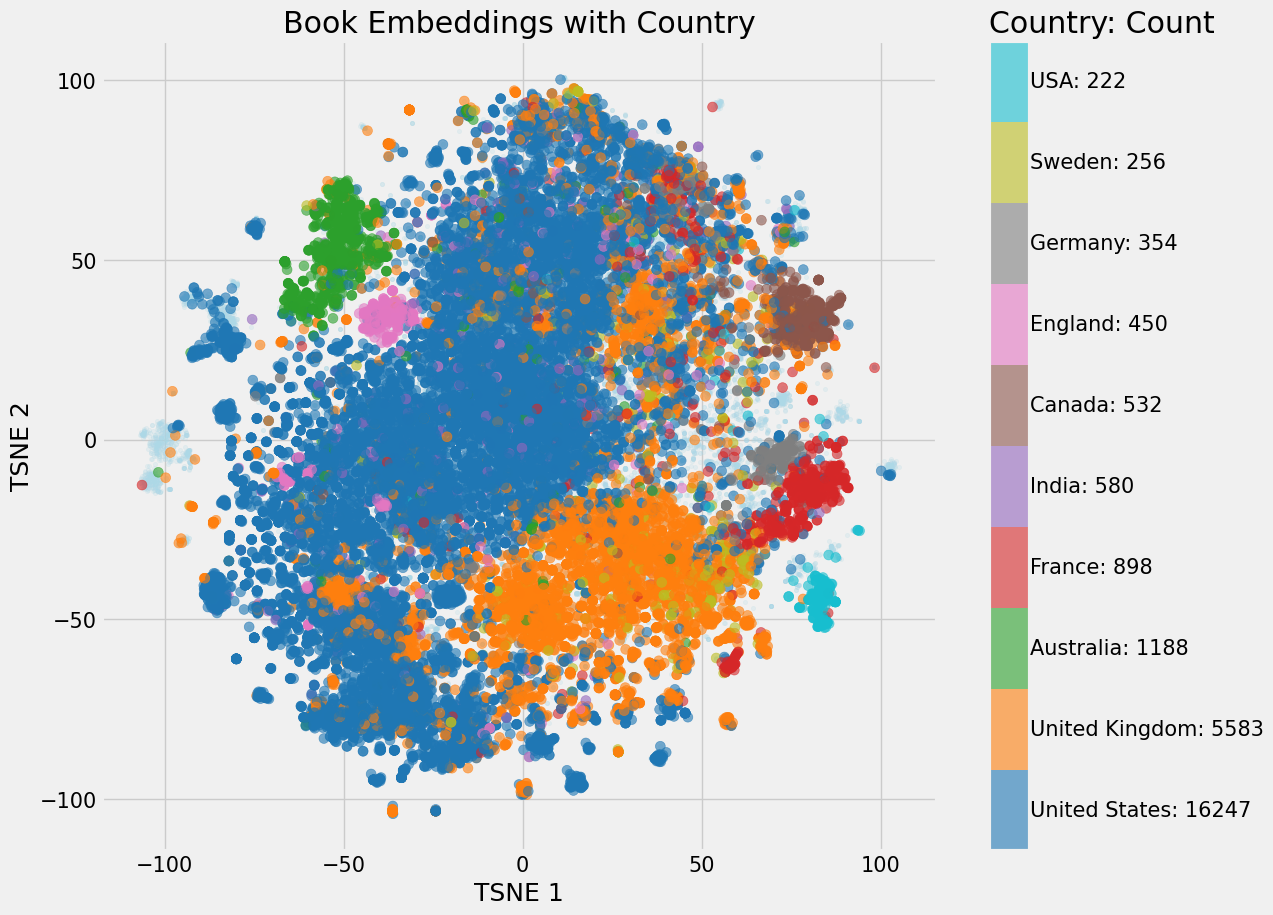

In [84]:
plot_by_attribute('country')

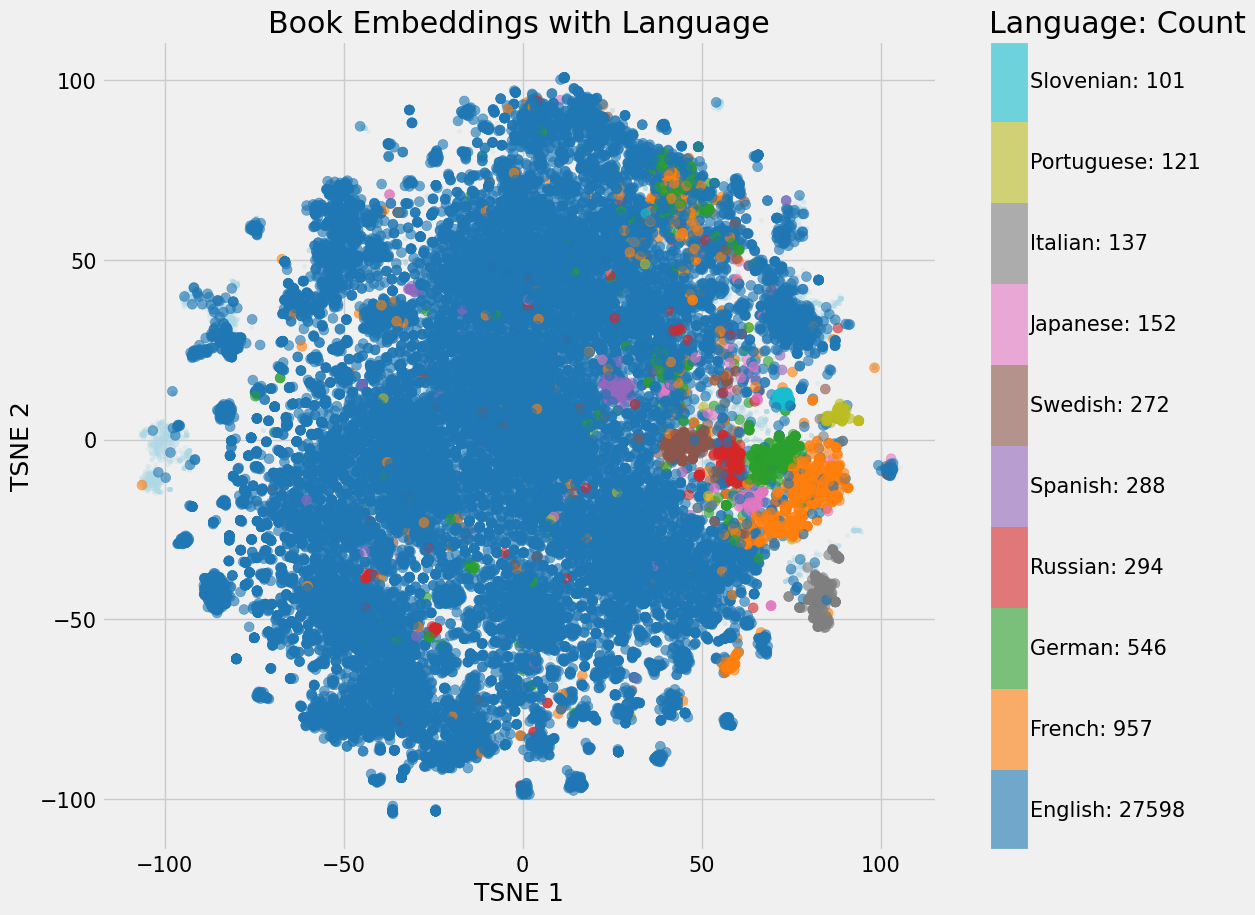

In [85]:
plot_by_attribute('language')

In [86]:
link_r = reduce_dim(link_weights_class, components = 2, method = 'tsne')
link_r.shape

(41758, 2)

In [87]:
idx_to_include = [idx for link, idx in link_index.items() if 'category:' in link]

categories = []

for book in books:
    for link in book[2]:
        if 'category:' in link.lower():
            categories.append(link)

c_counts = count_items(categories)
list(c_counts.items())[:5]

[('Category:American science fiction novels', 1289),
 ('Category:American novels adapted into films', 1139),
 ('Category:Debut novels', 1072),
 ('Category:American fantasy novels', 1036),
 ('Category:American young adult novels', 956)]

In [88]:
idx = []

# Find the index of the most popular links
for link in list(c_counts.keys())[:10]:
    link_idx = link_index[link.lower()]

    # Find index of category
    index = int(np.where(np.array(idx_to_include) == link_idx)[0])
    idx.append(index)

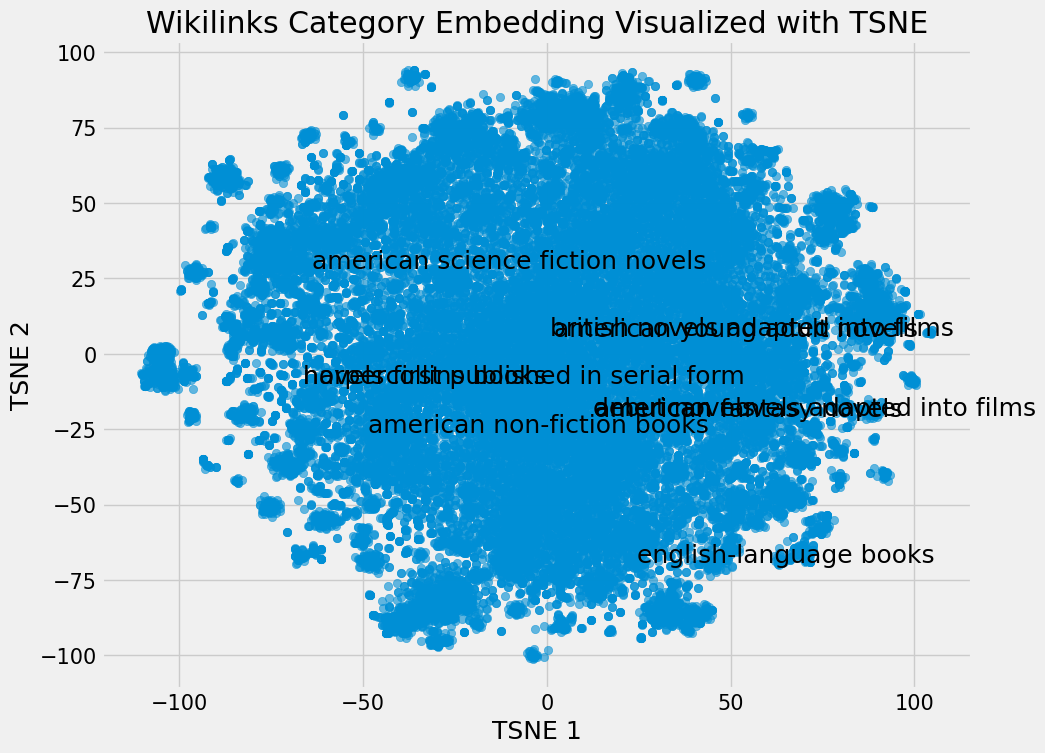

In [95]:
plt.figure(figsize = (10, 8))
plt.scatter(link_r[:, 0], link_r[:, 1], alpha = 0.6)

for i in idx:
    x, y = link_r[i, 0], link_r[i, 1]
    s = index_link[idx_to_include[i]].split(':')[-1]
    _ = plt.text(x, y, s, fontsize = 18);

plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title('Wikilinks Category Embedding Visualized with TSNE');

In [114]:
def plot_groups(items, weights, embed, index_name = 'book', n = 5):
    closest = []
    dists = []

    # Select index and reverse index
    if index_name == 'book':
        index = book_index
        rindex = index_book
    elif index_name == 'page':
        index = link_index
        rindex = index_link

    for item in items:
        d, c = find_similar(item, weights, index_name, n, return_dist = True)
        d = d[c]
        closest.extend(c)
        dists.extend(d)

    ax = plt.figure(figsize = (10, 8))
    p = plt.scatter(embed[:, 0], embed[:, 1], alpha = 0.2, marker = 'o', color =  'lightblue')

    cmap = plt.cm.get_cmap('tab10_r', len(items))
    color_list = []

    for i, item in enumerate(items):
         # Plot the item
        plt.scatter(embed[index[item], 0], embed[index[item], 1],
                    s = 200, alpha = 0.4, edgecolor = 'k', color = cmap(i))
        color_list.extend(i for _ in range(n))

    p = plt.scatter(embed[closest, 0], embed[closest, 1], c = color_list, cmap = cmap, s = 150,
                    marker = '*', alpha = 0.8)


    cbar = plt.colorbar(p)
    cbar.set_ticks([])

    tick_labels = []
    # Tick labeling for colorbar
    for item in items:
        name_str = ''
        for word in item.split():
            # Title uses latex for italize
            name_str += ' $\it{' + word + '}$'
        tick_labels.append(name_str)

    for j, lab in enumerate(tick_labels):
        cbar.ax.text(1, (2 * j + 1) / (len(tick_labels) / 2.5), lab, ha='left', va='center', size = 12)
    cbar.ax.set_title(f'Highlighted {index_name.capitalize()}s', loc = 'left', size = 14)
    plt.xlabel('TSNE 1'); plt.ylabel('TSNE 2'); plt.title(f'Embedded {index_name.capitalize()}s with Closest Neighbors');

<ipython-input-114-6d429d152a54>:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10_r', len(items))


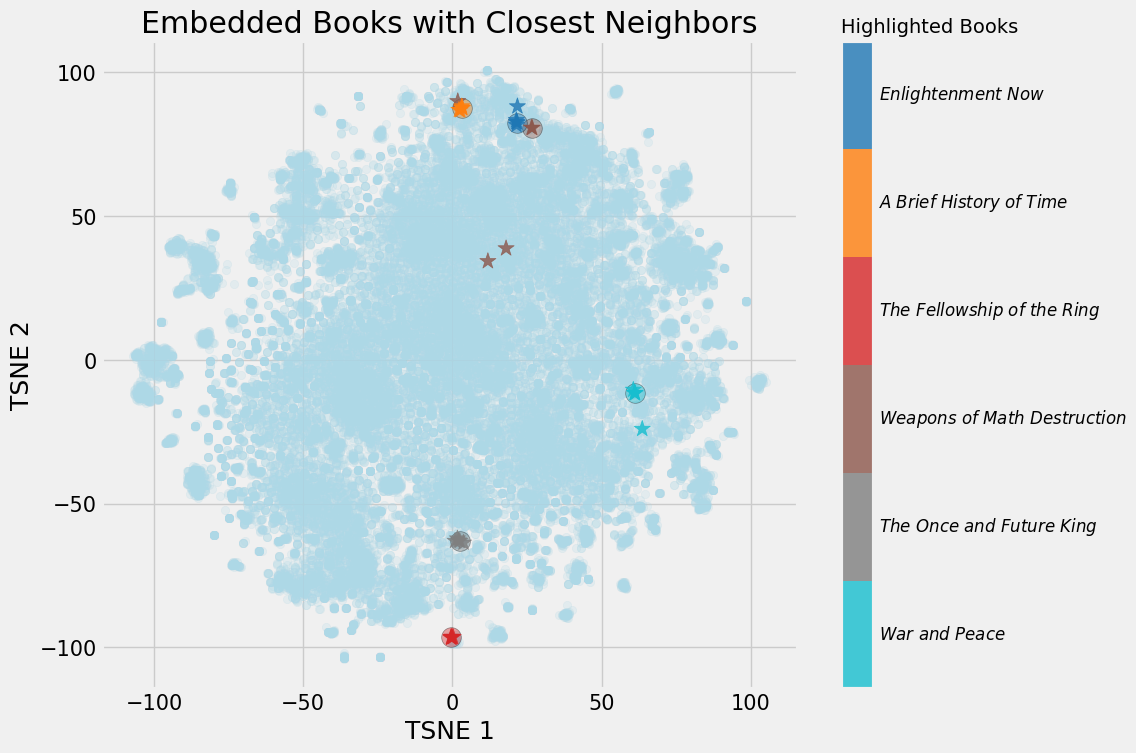

In [115]:
plot_groups(['War and Peace', "The Once and Future King",
             "Weapons of Math Destruction", "The Fellowship of the Ring",
             "A Brief History of Time", "Enlightenment Now"],
            book_weights_class, book_r, 'book')

<ipython-input-107-6d429d152a54>:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10_r', len(items))


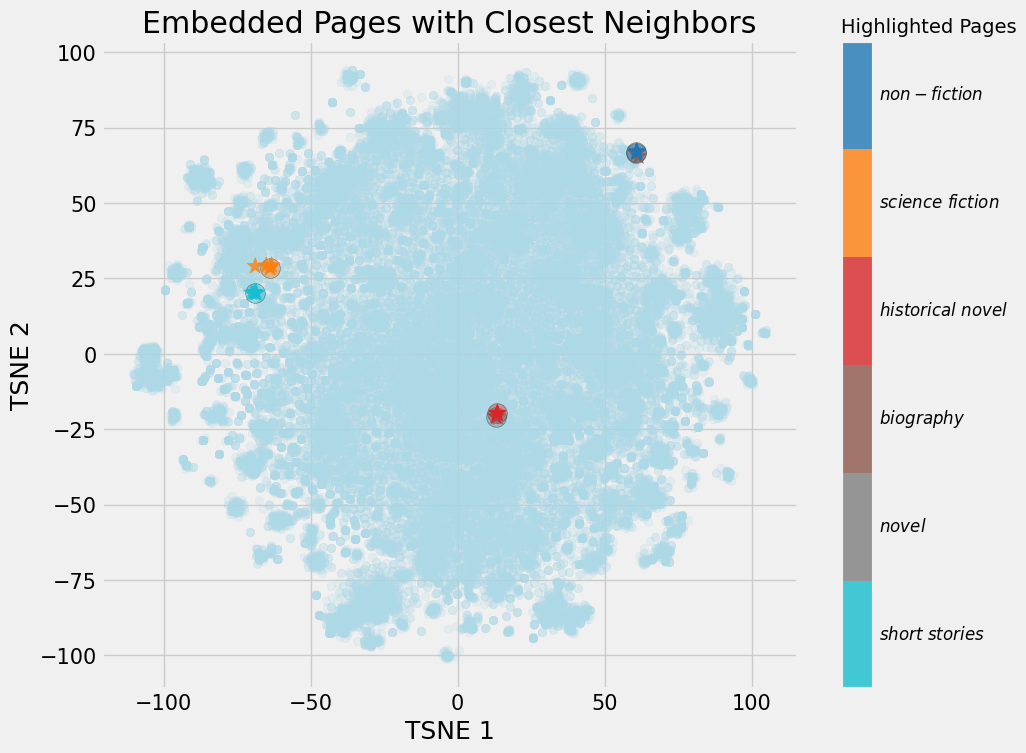

In [109]:
plot_groups(['short stories', 'novel',
            'biography', 'historical novel',
             'science fiction', 'non-fiction'],
            link_weights_class, link_r, 'page')

<ipython-input-110-e378d0ebd493>:2: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  plot_groups(list(random.sample(book_index.keys(), 6)),
<ipython-input-107-6d429d152a54>:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10_r', len(items))


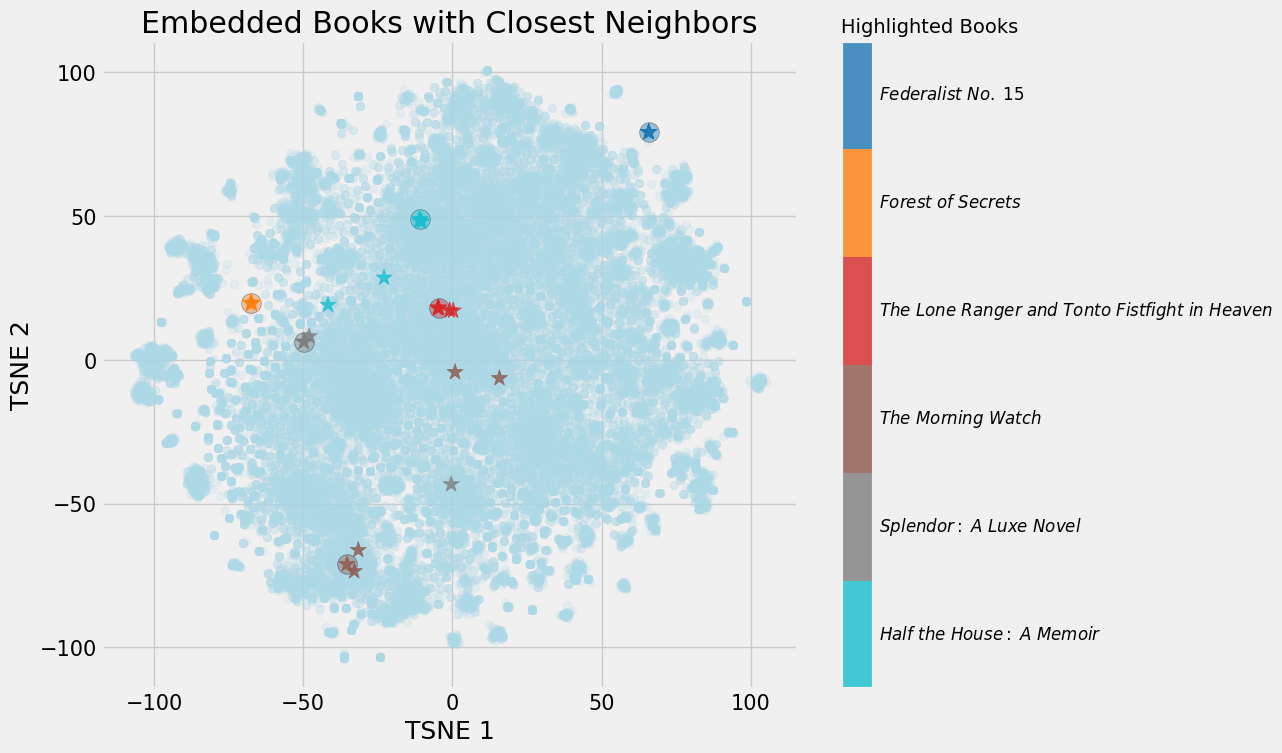

In [110]:
random.seed(150)
plot_groups(list(random.sample(book_index.keys(), 6)),
            book_weights_class, book_r, 'book')

<ipython-input-111-37db1e65900d>:2: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  plot_groups(list(random.sample(link_index.keys(), 6)), link_weights_class, link_r, 'page')
<ipython-input-107-6d429d152a54>:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10_r', len(items))


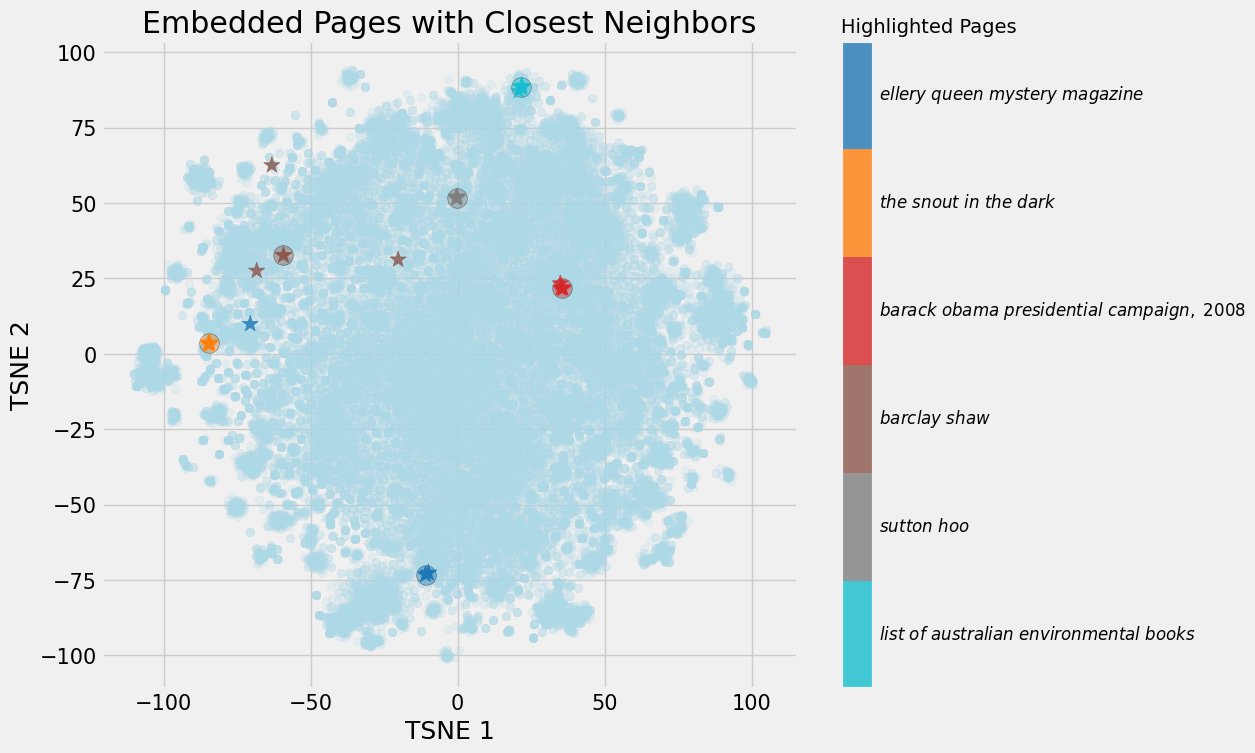

In [111]:
random.seed(150)
plot_groups(list(random.sample(link_index.keys(), 6)), link_weights_class, link_r, 'page')

In [116]:
%%capture
with open('/content/drive/MyDrive/Embedding/link_embedding.tsv', 'w' , encoding = 'utf-8') as fout:
    for l in link_index.keys():
        fout.write(str(l))
        fout.write('\n')

In [117]:
import re
pattern = re.compile('[\\n]|<.*?>')
pattern.sub('', 'bill moushey \n < br >').strip()

'bill moushey'

In [118]:
import re
pattern = re.compile('[\\n]|<.*?>')

# Extract book metadata
authors = []
genres = []
pages = []
languages = []
countries = []
publishers = []


for book in books:
    info = book[1]
    for attr, l in zip(['author', 'genre', 'pages', 'langauge', 'country', 'publisher'],
                        [authors, genres, pages, languages, countries, publishers]):
        l.append(pattern.sub('', info.get(attr, 'None').lower()).strip())

book_info = pd.DataFrame({'author': authors, 'genre': genres, 'pages': pages,
                          'language': languages, 'country': countries,
                          'publisher': publishers}, index = list(book_index.keys()))

book_info = book_info.replace({'none': np.nan})
book_info.index.name = 'title'
book_info.head()

author  \
title                                              
Freud: His Life and His Mind  helen walker puner   
Blackbox (novel)                     nick walker   
My Real Children                       jo walton   
The Alleys of Eden            robert olen butler   
Day of the Dogs                   andrew cartmel   

                                                              genre  \
title                                                                 
Freud: His Life and His Mind                                    NaN   
Blackbox (novel)                                                NaN   
My Real Children              fantasy literature, alternate history   
The Alleys of Eden                                              NaN   
Day of the Dogs                                     science fiction   

                                           pages  language         country  \
title                                                                        
Freud: His Life and His Mind  288 (1959 edition)       NaN   united states   
Blackbox (novel)                             NaN       NaN  united kingdom   
My Real Children                         320 pp.       NaN   united states   
The Alleys of Eden                        251 pp       NaN   united states   
Day of the Dogs                              256       NaN             NaN   

                                    publisher  
title                                          
Freud: His Life and His Mind  dell publishing  
Blackbox (novel)                harpercollins  
My Real Children                    tor books  
The Alleys of Eden                        NaN  
Day of the Dogs                   black flame

In [119]:
book_info.to_csv('/content/drive/MyDrive/Embedding/book_info.tsv', sep = '\t')

In [120]:
np.savetxt('/content/drive/MyDrive/Embedding/book_embedding.tsv', book_weights_class, delimiter='\t')
np.savetxt('/content/drive/MyDrive/Embedding/link_embedding.tsv', link_weights_class, delimiter='\t')

In [121]:
book_embedding = np.loadtxt('/content/drive/MyDrive/Embedding/book_embedding.tsv', delimiter = '\t')
book_embedding.shape

(37020, 50)